In [1]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import pandas as pd  
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import seaborn as sns

import numpy as np

In [2]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
ds = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')

In [4]:
list_ = []  
for i in range(len(ds['package_name'].unique())):
    ds_aux = ds.loc[ds['package_name'] == ds['package_name'].unique()[i]]
    list_.append({'package_name':ds['package_name'].unique()[i], 'size': len(ds_aux)})

list_ = sorted(list_, key=lambda x: x['size'], reverse=True)
df = ds[ds['package_name'] == list_[8]['package_name']]
corpus = list(df['review'])

ds_new = pd.DataFrame(corpus)
print(ds_new)

                                                      0
0                                 Authentication Morris
1     I can't access my account We couldn't verify y...
2     This app works fine Later found the secret key...
3                                     very good love it
4       Powerful app Awesome app to safe my transaction
...                                                 ...
2971                              I'm feeling very well
2972              Doesn't work  can't add any accounts.
2973  Only one concern but not sure if it was the ap...
2974                                           Verygood
2975  This is very bad and not change password and v...

[2976 rows x 1 columns]


In [5]:
''''
length = np.sqrt((X**2).sum(axis=1))[:,None]
X = X / length

kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

#centroides
len_ = np.sqrt(np.square(kmeans.cluster_centers_).sum(axis=1)[:,None])
centers = kmeans.cluster_centers_ / len_
dist = 1 - np.dot(centers, X.T) # K x N matrix of cosine distances
'''

corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
corpus_embeddings = preprocessing.normalize(corpus_embeddings)
#corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)



In [6]:
cosine_scores = util.cos_sim(corpus_embeddings, corpus_embeddings)

In [7]:
score = []
for k in range(1, 11):
    clustering_model = KMeans(n_clusters=k)
    clustering_model.fit(corpus_embeddings)
    score.append(clustering_model.inertia_)

In [8]:
best_kmeans = 0
best_score = 10000000
for i in range(len(score)):
    if(score[i] < best_score):
        best_score = score[i]
        best_kmeans = i+1
print("best score: ", best_score)
print("best k: ", best_kmeans)

best score:  1947.1758132094892
best k:  10


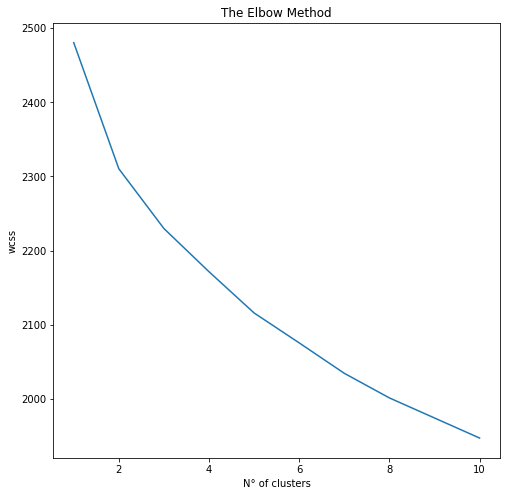

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('N° of clusters')
plt.ylabel('wcss')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.07573415827809689
[0 1 1 ... 1 0 1]
For n_clusters = 3 The average silhouette_score is : 0.057167939044481086
[0 0 0 ... 0 1 0]
For n_clusters = 4 The average silhouette_score is : 0.057383754304623856
[2 2 2 ... 2 3 2]
For n_clusters = 5 The average silhouette_score is : 0.048197563324304485
[2 2 4 ... 2 0 2]
For n_clusters = 6 The average silhouette_score is : 0.05002037007215763
[4 1 5 ... 1 0 1]
For n_clusters = 7 The average silhouette_score is : 0.049982710959802196
[5 6 5 ... 6 3 6]
For n_clusters = 8 The average silhouette_score is : 0.055975764041811205
[1 7 1 ... 7 0 7]
For n_clusters = 9 The average silhouette_score is : 0.05820428948420958
[1 1 1 ... 5 0 5]
For n_clusters = 10 The average silhouette_score is : 0.059515927233950265
[1 1 1 ... 8 6 7]


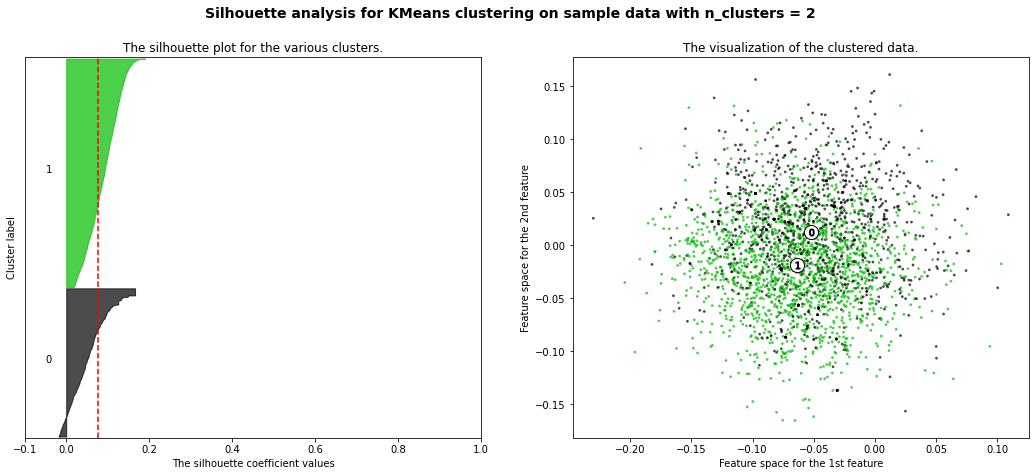

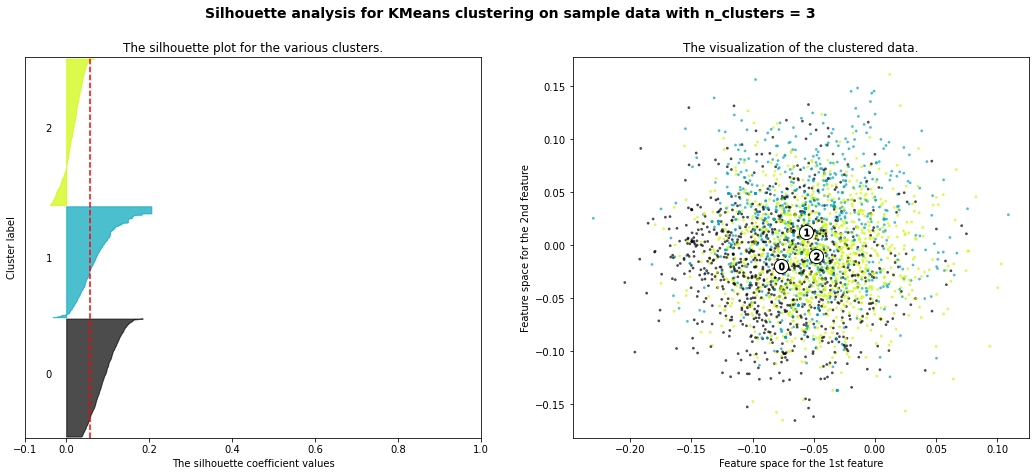

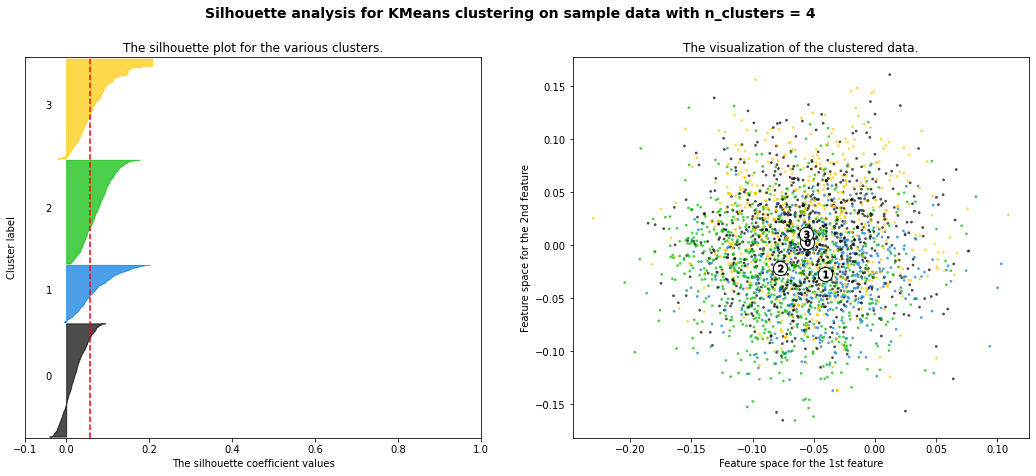

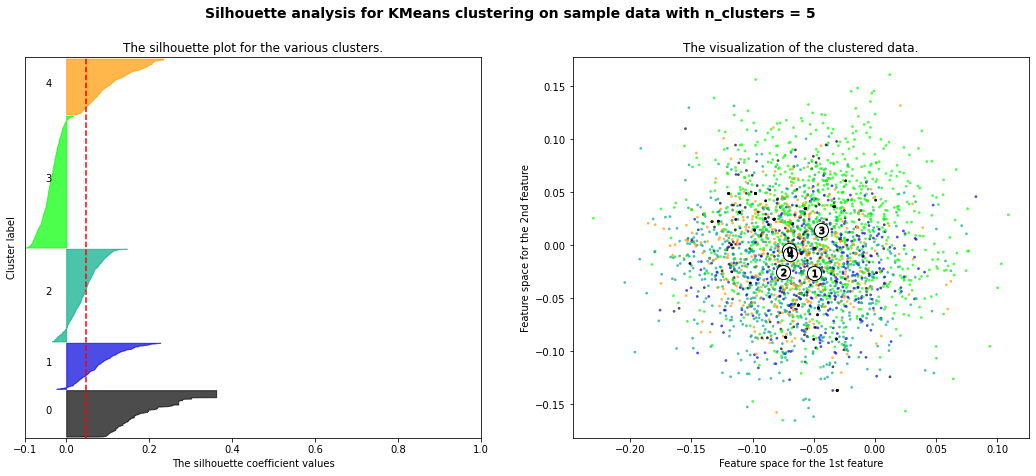

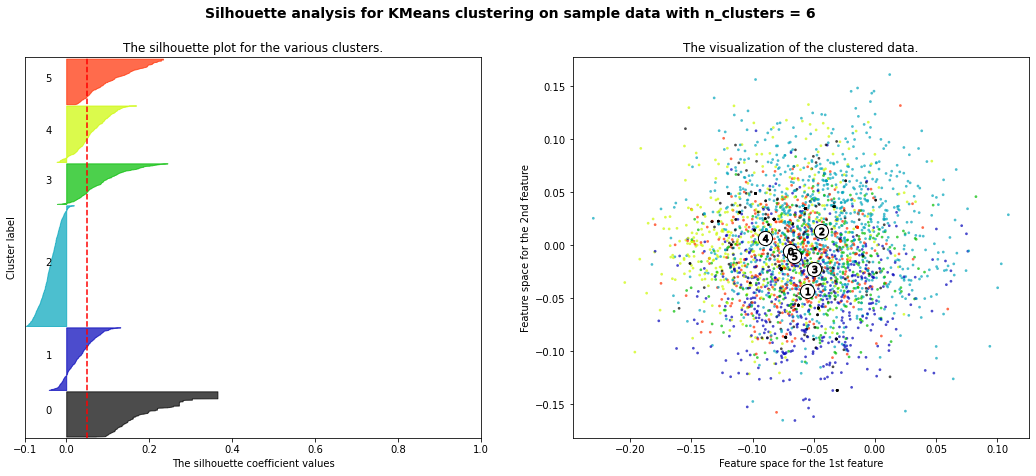

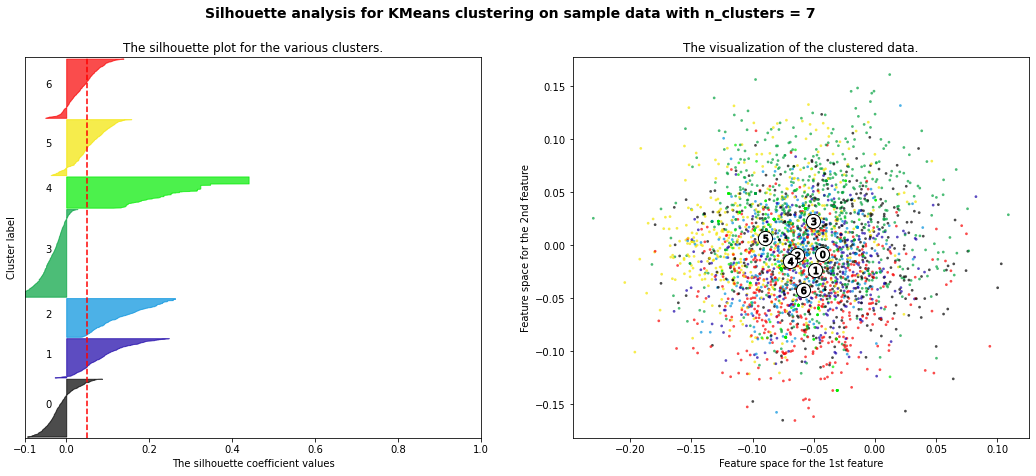

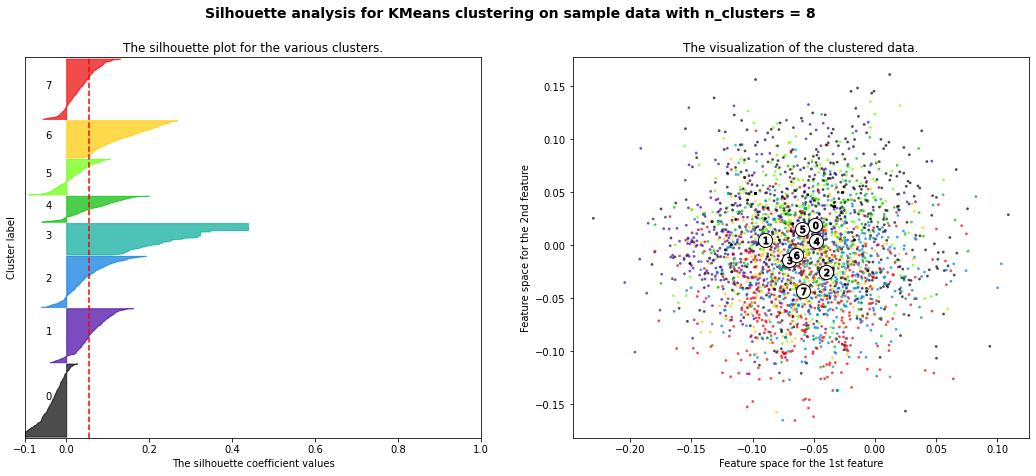

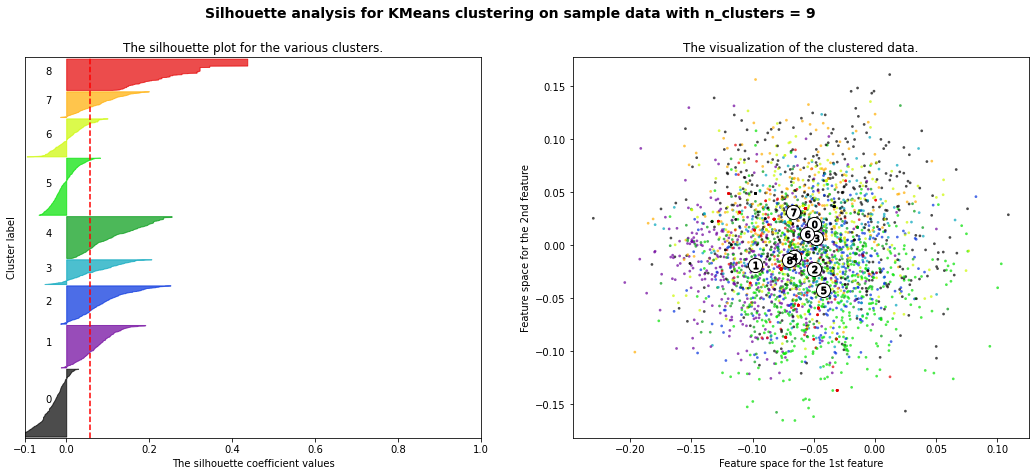

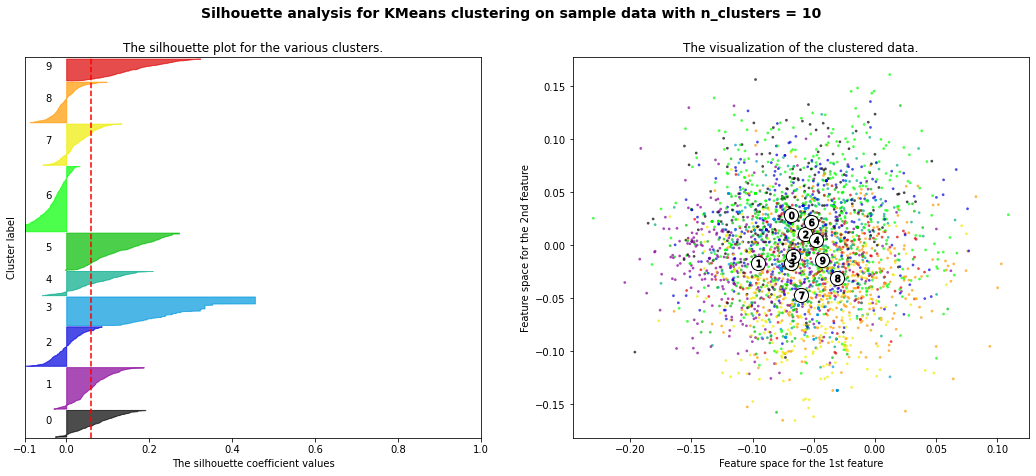

best avg:  0.07573415827809689
best k:  2


In [10]:
average_best = 0
best_k = 0
for k in range(2,11):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(corpus_embeddings) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, init="k-means++", random_state=10)
    cluster_labels = clusterer.fit_predict(corpus_embeddings)

    silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    if(silhouette_avg > average_best): 
        average_best = silhouette_avg
        best_k = k
        ds_new['clusters'] = cluster_labels
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    print(cluster_labels)

    #print(cluster_labels)

    sample_silhouette_values = silhouette_samples(corpus_embeddings, cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(corpus_embeddings[:, 0], corpus_embeddings[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')      

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()
print("best avg: ", average_best)
print("best k: ", best_k)

In [11]:
ds_new

,0,clusters
0,Authentication Morris,0
1,I can't access my account We couldn't verify y...,1
2,This app works fine Later found the secret key...,1
3,very good love it,0
4,Powerful app Awesome app to safe my transaction,1
...,...,...
2971,I'm feeling very well,0
2972,Doesn't work can't add any accounts.,1
2973,Only one concern but not sure if it was the ap...,1
2974,Verygood,0


In [12]:
ds_new['clusters'] = ['cluster_' + str(cluster) for cluster in ds_new['clusters']]
ds_new.sort_values(by = ['clusters'])

,0,clusters
0,Authentication Morris,cluster_0
1641,nice 😎,cluster_0
1640,Simple and does what it's intended to do.,cluster_0
1639,Love it,cluster_0
1637,yes I would like it.,cluster_0
...,...,...
1604,Can't Add Google account to device with 2-step...,cluster_1
577,Error Keep disappearing after download.,cluster_1
1601,Install give my good and liunding,cluster_1
1599,Probably the most important app on my phone I...,cluster_1


In [13]:
corpus_2 = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.'
          ]
corpus_embeddings_2 = embedder.encode(corpus_2)

# Perform kmean clustering
num_clusters = 5
clustering_model_2 = KMeans(n_clusters=num_clusters)
clustering_model_2.fit(corpus_embeddings_2)
cluster_assignment = clustering_model_2.labels_

clustered_sentences_2 = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences_2[cluster_id].append(corpus_2[sentence_id])
print(clustered_sentences_2)
center_2 = clustering_model_2.cluster_centers_
print("center : ",center_2)
print("centers[:, 0] : ", centers[:, 0])
print("centers[:, 1] : ", centers[:, 1])
print("sdasdasdasdad : ", centers[:1])

for i, cluster in enumerate(clustered_sentences_2):
    print("Cluster ", i+1)
    print(cluster)
    print("")

[['The girl is carrying a baby.', 'The baby is carried by the woman'], ['A man is eating food.', 'A man is eating a piece of bread.', 'A man is eating pasta.'], ['A cheetah is running behind its prey.', 'A cheetah chases prey on across a field.'], ['A monkey is playing drums.', 'Someone in a gorilla costume is playing a set of drums.'], ['A man is riding a horse.', 'A man is riding a white horse on an enclosed ground.']]
center :  [[-0.05627082 -0.02621724 -0.05728881 ... -0.03951702  0.11970837
  -0.00428921]
 [ 0.02472616  0.00294538 -0.0130505  ...  0.04504786 -0.02498251
  -0.03937866]
 [ 0.03861746  0.07901674 -0.01882337 ...  0.01769911  0.03022731
   0.05294377]
 [-0.00612485 -0.02084715  0.05041325 ...  0.04162261  0.0515007
   0.01486638]
 [ 0.01618075  0.00425246  0.0453069  ...  0.00218675  0.05853743
  -0.00377093]]
centers[:, 0] :  [-0.06892484 -0.09515762 -0.05747513 -0.06875579 -0.04783936 -0.06702694
 -0.05208753 -0.06043736 -0.0313314  -0.04355062]
centers[:, 1] :  [ 0